In [53]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/shape-recognition/'
%cd /content/drive/MyDrive/shape-recognition/
!git status


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/shape-recognition
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   data.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [1]:
#initialize environment, load modules/libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mppatch
import xml.etree.ElementTree as ET

#import python code from seperate files
from utils.generators import gen_shapes, gen_noise, gen_image, gen_details
from utils.helpers import gen_grid_image

rnd=np.random.default_rng(31)


In [2]:
folder=["train","validate","test"] 
num_images={"train":10, "validate":3, "test":3}

num_shapes=50
max_radius=1/20
min_radius=1/40

num_noise=500
max_line=1/10
min_line=1/80

im_size=1024
max_lw=0.5
min_lw=0.1
min_gray=0.7

radius = int(max_radius*im_size)+1
detail_im_size = 2*radius+1

fluct=0

In [3]:
for name in folder:
    for i in range(num_images[name]):
        shapes = gen_shapes(rnd, num_shapes, max_radius, min_radius, False, False)
        noise = gen_noise(rnd, num_noise, max_line, min_line)
        img, sha, nse, box = gen_image(shapes, noise, im_size, max_lw, min_lw, min_gray, False)
        focus = gen_details(detail_im_size, sha, img, rnd, fluct)

        target = name+"/"+name+f"{i:04d}"
        np.savez_compressed("data/"+target+".npz", image=img, shapes=sha, details=focus, boxes=box)

    plt.close()

In [4]:
for name in folder:
    for i in range(num_images[name]):
        source = name+"/"+name+f"{i:04d}"
        loaded  = np.load("data/"+source+".npz")
        image = loaded['image']
        shapes = loaded['shapes']
        details = loaded['details']
        boxes = loaded['boxes']

        fig = plt.figure(figsize=(image.shape[1],image.shape[0]),dpi=1)
        fig.figimage(image, cmap='gray')
        fig.savefig("data/"+source+".jpg")
        plt.close()


In [58]:
for name in folder:
    for i in range(num_images[name]):
        filename = name+f"{i:04d}"
        source = name+"/"+ filename
        loaded  = np.load("data/"+source+".npz")
        shapes = loaded['shapes']
        boxes = loaded['boxes']

        annotation=ET.Element('annotation')
        ET.SubElement(annotation,'folder')
        ET.SubElement(annotation,'filename').text=filename+".jpg"
        ET.SubElement(annotation,'path').text=filename+".jpg"
        ET.SubElement(annotation,'source').text='synthetic'
        ET.SubElement(annotation,'segmented').text='0'
        size=ET.SubElement(annotation,'size')
        ET.SubElement(size,'width').text=f"{im_size}"
        ET.SubElement(size,'height').text=f"{im_size}"
        ET.SubElement(size,'depth').text='1'

        for k in range(num_shapes):
          obj=ET.SubElement(annotation,'object')
          ET.SubElement(obj,'name').text=f"{int(shapes[k][0])}"
          ET.SubElement(obj,'pose').text='Unspecified'
          ET.SubElement(obj,'truncated').text='0'
          ET.SubElement(obj,'difficult').text='0'
          ET.SubElement(obj,'occluded').text='0'
          box=ET.SubElement(obj,'bndbox')
          ET.SubElement(box,'xmin').text=f"{int(boxes[k][0]+0.5)}"
          ET.SubElement(box,'xmax').text=f"{int(boxes[k][1]+0.5)}"
          ET.SubElement(box,'ymin').text=f"{im_size-int(boxes[k][3]+0.5)}"
          ET.SubElement(box,'ymax').text=f"{im_size-int(boxes[k][2]+0.5)}"

        ET.ElementTree(annotation).write("data/"+source+".xml")

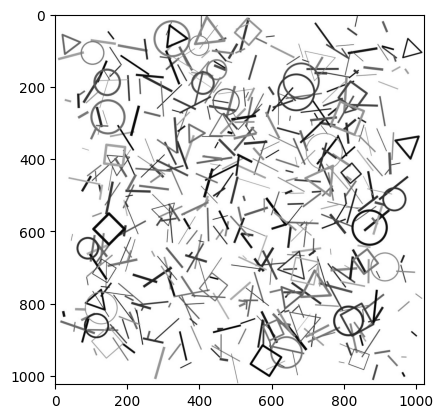

In [59]:
plt.imshow(mpimg.imread("data/"+source+".jpg"))
#plt.gca().add_patch(mppatch.Rectangle((348,831),97,96,linewidth=1,edgecolor='g',facecolor='none'))

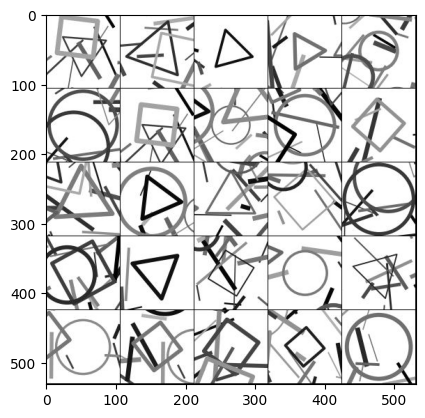

In [60]:
grid = (5,5)
grid_image, grid_pos = gen_grid_image(details, grid)

fig = plt.figure(figsize=(grid_image.shape[1],grid_image.shape[0]),dpi=1)
fig.figimage(grid_image, cmap='gray')
fig.savefig('data/tmp_grid.jpg')
plt.close()

plt.imshow(mpimg.imread('data/tmp_grid.jpg'))

In [61]:
print("\nposition : shape : [pos_x, pos_y, size, rotation, line_width]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {int(shapes[i][0])} {shapes[i][1:]}")


position : shape : [pos_x, pos_y, size, rotation, line_width]
(0, 0) : 3 [173.858 612.561  36.113   0.967   0.169]
(0, 1) : 3 [660.848 324.895  44.984   1.747   0.269]
(0, 2) : 3 [984.835 925.732  31.478   0.266   0.262]
(0, 3) : 3 [385.887 693.711  28.922   0.55    0.373]
(0, 4) : 2 [447.401 869.863  27.011   0.      0.324]
(1, 0) : 2 [681.324 838.437  48.81    0.      0.359]
(1, 1) : 4 [165.023 632.937  36.839   0.662   0.489]
(1, 2) : 2 [398.369 936.648  27.22    0.      0.163]
(1, 3) : 2 [640.673  87.4    42.463   0.      0.347]
(1, 4) : 4 [534.265 974.756  36.914   0.063   0.362]
(2, 0) : 3 [721.049 266.754  47.304   0.055   0.456]
(2, 1) : 3 [331.287 960.295  35.35    0.407   0.393]
(2, 2) : 3 [463.143 707.438  40.589   2.087   0.227]
(2, 3) : 4 [145.281 115.268  43.842   1.5     0.189]
(2, 4) : 2 [667.809 807.165  49.753   0.      0.367]
(3, 0) : 4 [835.445 177.942  46.721   1.286   0.381]
(3, 1) : 3 [977.538 660.821  37.823   1.218   0.399]
(3, 2) : 4 [136.643 313.071  33.747 

In [62]:
print("\nposition : [x_min, x_max, y_min, y_max]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {boxes[i]}")


position : [x_min, x_max, y_min, y_max]
(0, 0) : [144.123 206.474 576.563 633.054]
(0, 1) : [616.565 689.837 290.498 367.199]
(0, 2) : [ 962.67  1015.273  903.382  956.103]
(0, 3) : [370.77  414.8   668.291 718.368]
(0, 4) : [420.39  474.412 842.853 896.874]
(1, 0) : [632.513 730.134 789.626 887.247]
(1, 1) : [135.974 194.072 603.888 661.986]
(1, 2) : [371.15  425.589 909.429 963.868]
(1, 3) : [598.21  683.136  44.937 129.863]
(1, 4) : [ 497.424  571.106  937.915 1011.597]
(2, 0) : [681.455 763.263 240.869 313.985]
(2, 1) : [310.185 366.399 931.934 992.75 ]
(2, 2) : [427.835 498.135 686.869 748.026]
(2, 3) : [101.549 189.012  71.537 158.999]
(2, 4) : [618.056 717.562 757.412 856.918]
(3, 0) : [790.604 880.286 133.101 222.783]
(3, 1) : [ 942.049 1006.612  623.546  685.014]
(3, 2) : [103.828 169.458 280.256 345.886]
(3, 3) : [ 72.521 135.142 884.96  947.58 ]
(3, 4) : [267.612 330.573 437.89  501.079]
(4, 0) : [874.588 951.818 285.424 362.655]
(4, 1) : [825.216 894.104 304.456 373.344]
(